# SeriesMatrix チュートリアル

行列要素ごとのメタデータ（unit/name/channel）を持つ `SeriesMatrix` の基本と、線形代数系メソッド（trace/diagonal/det/inv/schur）、サンプル軸編集、表示を一通り試します。表示系はクラスが持つメソッド (`plot`, `step`, `__repr__`, `_repr_html_`) をそのまま使い、追加のユーティリティ関数は定義しません。

In [1]:
#%matplotlib inline
#from matplotlib_inline.backend_inline import set_matplotlib_formats
#set_matplotlib_formats("svg")
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline", force=True)

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from IPython.display import display

from gwexpy.types.seriesmatrix import SeriesMatrix
from gwexpy.types.metadata import MetaData
from gwpy.types.series import Series

np.set_printoptions(precision=4, suppress=True)
plt.rcParams.update({"figure.figsize": (5, 3), "axes.grid": True})

## 代表データを用意
- `sm_eq`: 全要素同一単位（線形代数系の基準）
- `sm_equiv`: m と cm の混在（換算確認用）
- `sm_mixed`: m と s など非等価混在（エラー確認用）

In [2]:
xindex = np.array([0.0, 1.0, 2.0]) * u.s

sm_eq = SeriesMatrix(
    np.array([
        [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]],
        [[7.0, 8.0, 9.0], [10.0, 11.0, 12.0]],
    ]),
    xindex=xindex,
    units=np.full((2, 2), u.m),
    rows={"r0": {"name": "row0"}, "r1": {"name": "row1"}},
    cols={"c0": {"name": "col0"}, "c1": {"name": "col1"}},
    name="eq",
)

sm_equiv = SeriesMatrix(
    np.array([
        [[1.0, 2.0, 3.0], [40.0, 50.0, 60.0]],
        [[700.0, 800.0, 900.0], [10.0, 11.0, 12.0]],
    ]),
    xindex=xindex,
    units=np.array([[u.m, u.m], [u.cm, u.m]]),
    name="equiv",
)

sm_mixed = SeriesMatrix(
    np.ones((2, 2, 3)),
    xindex=xindex,
    units=np.array([[u.m, u.s], [u.m, u.s]]),
    name="mixed",
)

print(sm_eq)
print("要素単位:\n", sm_eq.meta.units)

SeriesMatrix(shape=(2, 2, 3),  name='eq')
  epoch   : 0.0
  x0      : 0.0 s
  dx      : 1.0 s
  xunit   : s
  samples : 3

[ Row metadata ]
     name channel unit
key                   
r0   row0             
r1   row1             

[ Column metadata ]
     name channel unit
key                   
c0   col0             
c1   col1             

[ Elements metadata ]
  unit  name channel  row  col
0    m  None    None    0    0
1    m  None    None    0    1
2    m  None    None    1    0
3    m  None    None    1    1
要素単位:
 [[Unit("m") Unit("m")]
 [Unit("m") Unit("m")]]


## 多様な入力パターン（コンストラクタ例）
`test_SeriesMatrix.ipynb` で試している入力パターンをここでも確認します。

In [3]:
print("=== SeriesMatrix コンストラクタ例 ===")
from gwpy.types.index import Index
from gwpy.types.array import Array

# 共通の xindex
ix = Index(np.linspace(0, 1, 5), unit='s')

# ケース 1: unit/name/channel 明示
data = np.random.randn(2, 2, 5)
units = [[u.m, u.s], [u.kg, u.N]]
names = [["x", "y"], ["m", "F"]]
channels = [[None, None], ["CH1", "CH2"]]
sm = SeriesMatrix(data, xindex=ix, units=units, names=names, channels=channels)
print("case1", sm.shape, sm['row0','col0'].unit, sm['row1','col1'].name)

# ケース 2: Series だけで構築（units 指定なし）
s1 = Series(np.ones(5), xindex=ix, unit='m', name='x')
s2 = Series(np.zeros(5), xindex=ix, unit='s', name='y')
sm2 = SeriesMatrix([[s1, s2]])
print("case2", sm2.shape, sm2['row0','col1'].unit)

# ケース 3: スカラー配列 + units 指定（x0/dx/xunit でサンプル軸定義）
data2 = [[np.pi, 1.0], [2.0, 3.0]]
units2 = [[u.s, u.s], [u.s, u.s]]
sm3 = SeriesMatrix(data2, x0=0, dx=1, xunit='s', units=units2)
print("case3", sm3.shape, sm3['row0','col1'].unit)

# ケース 4: 1D Quantity -> (1,1,K)
sm4 = SeriesMatrix(np.linspace(0, 1, 5) * u.m, x0=0, dx=1, xunit='s')
print("case4", sm4.shape, sm4['row0','col0'].unit)

# ケース 5: 1D list mixed (Series, Array, scalar Quantity)
data_mix = [
    Series(np.random.randn(5), xindex=ix, unit='m'),
    Array(np.arange(5), unit='m'),
    1.23 * u.m,
]
sm5 = SeriesMatrix(data_mix, x0=0, dx=1, xunit='s')
print("case5", sm5.shape, sm5['row0','col0'].unit, sm5['row1','col0'].unit)

# ケース 6: 3D Quantity (複素もOK)
qdata = (np.random.randn(2, 3, 5) + 1j*np.random.randn(2, 3, 5)) * u.m
sm6 = SeriesMatrix(qdata, x0=0, dx=1, xunit='s')
print("case6", sm6.shape, sm6['row1','col2'].unit)

=== SeriesMatrix コンストラクタ例 ===
case1 (2, 2, 5) m F
case2 (1, 2, 5) s
case3 (2, 2, 1) s
case4 (1, 1, 5) m
case5 (3, 1, 5) m m
case6 (2, 3, 5) m


## 参照・切り出し
- `__getitem__` で Series を取得
- `diagonal` で対角抽出（list / vector / matrix）
- `value_at` でサンプル位置の 2D 値を取得

In [4]:
s00 = sm_eq[0, 0]
print("[0,0]", s00, s00.value, s00.unit)

diag_list = sm_eq.diagonal("list")
print("diag list len", len(diag_list))
diag_vector = sm_eq.diagonal("vector")
diag_matrix = sm_eq.diagonal("matrix")
print("diag vector shape", diag_vector.shape)
print("diag matrix off-diagonal", diag_matrix.value[0,1])

v_at_1 = sm_eq.value_at(xindex[1])
print("value_at t=1s:\n", v_at_1)

[0,0] Series([1., 2., 3.]
       unit: m,
       name: None,
       epoch: None,
       channel: None,
       x0: 0.0 s,
       dx: 1.0 s,
       xindex: [0. 1. 2.] s) [1. 2. 3.] m
diag list len 2
diag vector shape (2, 1, 3)
diag matrix off-diagonal [0. 0. 0.]
value_at t=1s:
 [[ 2.  5.]
 [ 8. 11.]]


## サンプル軸編集
- `crop`: サンプル区間切り出し
- `diff`: サンプル軸方向の差分
- `pad`: 正則サンプル軸の前後にパディング

プロットはクラスメソッド `plot` を直接呼びます。

cropped shape (2, 2, 1) xindex [1.]
diffed shape (2, 2, 2)
padded shape (2, 2, 5) xindex [-1.  0.  1.  2.  3.]


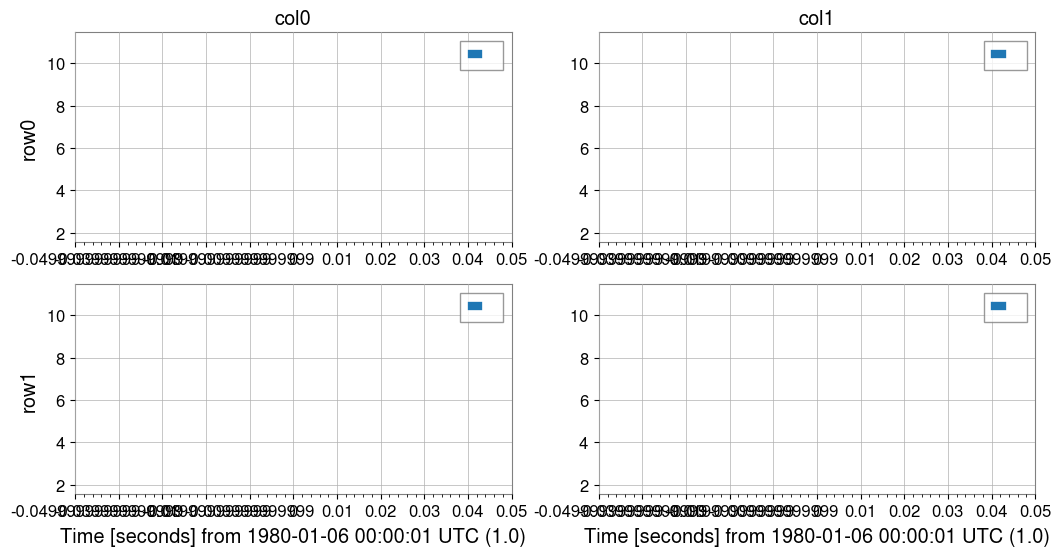

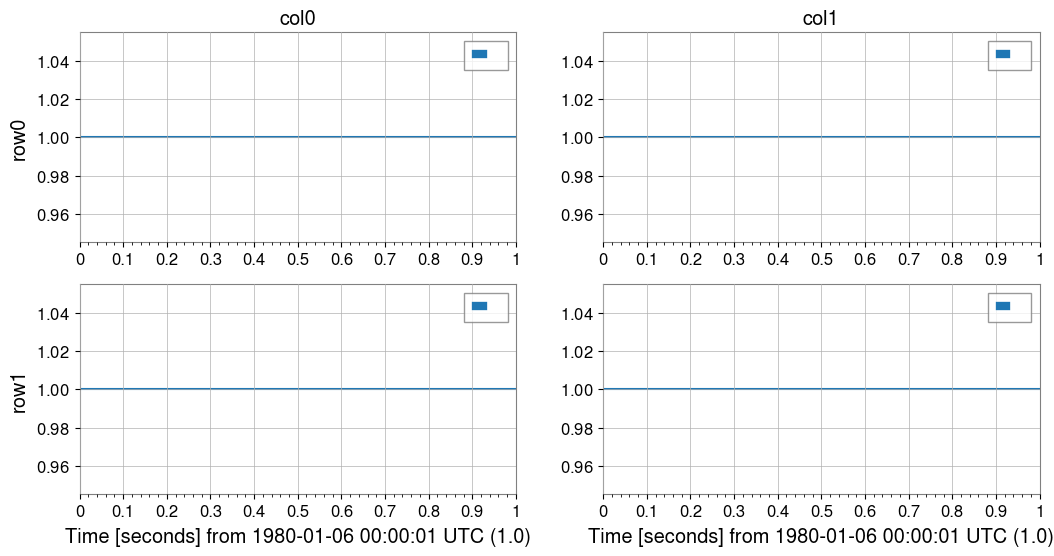

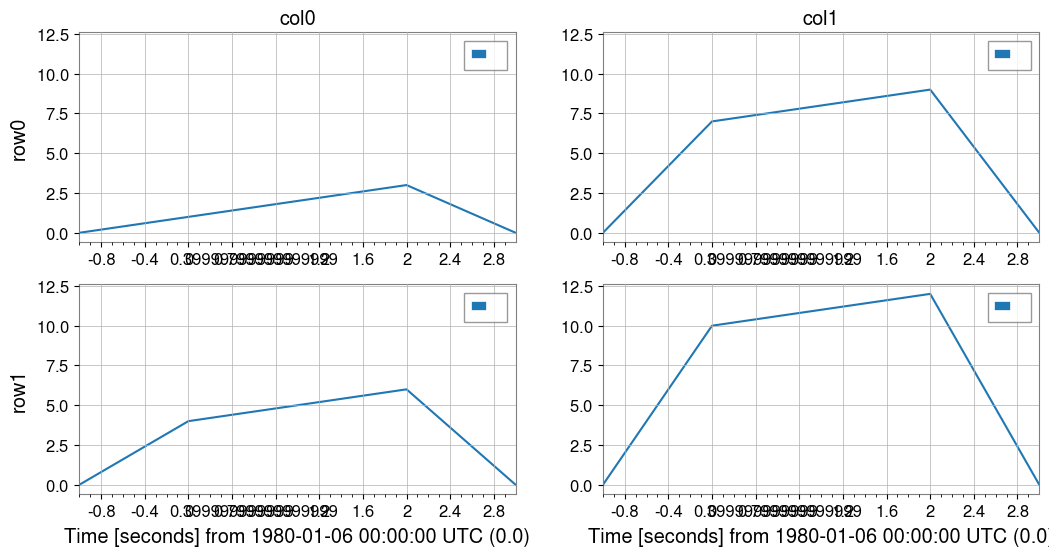

In [5]:
cropped = sm_eq.crop(start=0.5*u.s, end=1.5*u.s)
print("cropped shape", cropped.shape, "xindex", np.asarray(cropped.xindex))
cropped.plot(subplots=True);

diffed = sm_eq.diff(n=1)
print("diffed shape", diffed.shape)
diffed.plot(subplots=True);

padded = sm_eq.pad(1)
print("padded shape", padded.shape, "xindex", np.asarray(padded.xindex))
padded.plot(subplots=True);

## 演算（ufunc 例）
- 比較演算は bool + unit 無次元
- `floor_divide` は単位を除算
- `astype` は dtype 変換のみ（メタ保持）

In [6]:
less_mask = sm_eq < (2 * sm_eq)
print("less_mask dtype", less_mask.value.dtype, "unit", less_mask.meta[0,0].unit)

floordiv = np.floor_divide(sm_eq, 2*u.s)
print("floordiv unit", floordiv.meta[0,0].unit)

as_float = sm_eq.astype(float)
print("astype dtype", as_float.value.dtype)

less_mask dtype bool unit m
floordiv unit m / s
astype dtype float64


## 線形代数（unit-aware）
- `trace`: 対角を共通単位に換算して加算
- `det`: 全要素単位が等価な場合のみ
- `inv`: 全要素単位を揃えた逆行列（swap_rowcol=True でラベルも転置）
- `schur`: 指定ブロックのシュア補完（全要素単位等価が前提）

trace unit m values [11. 13. 15.]
det unit m2 values [-18. -18. -18.]
inv shape (2, 2, 3) row keys ('c0', 'c1') col keys ('r0', 'r1')
schur shape (1, 1, 3) unit m


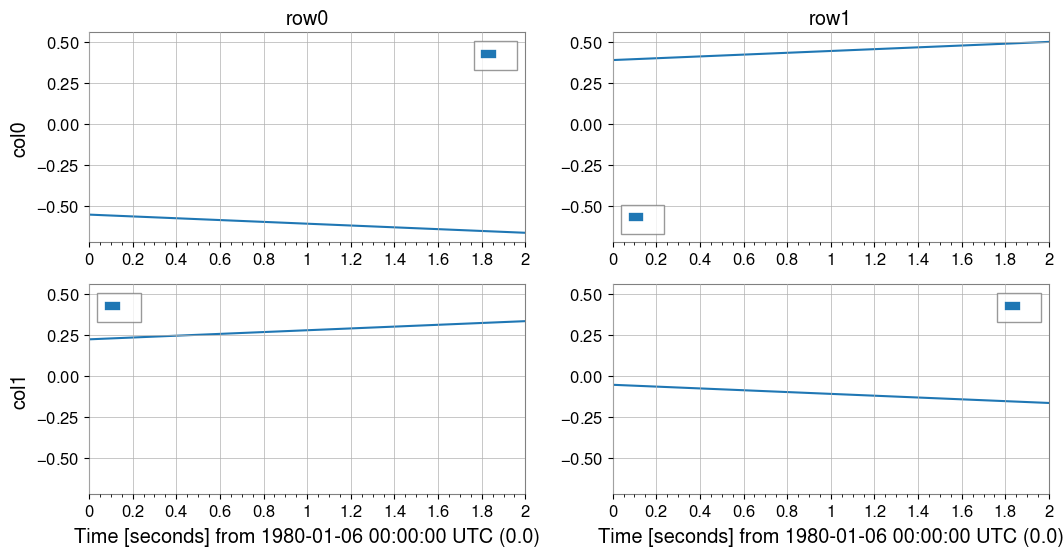

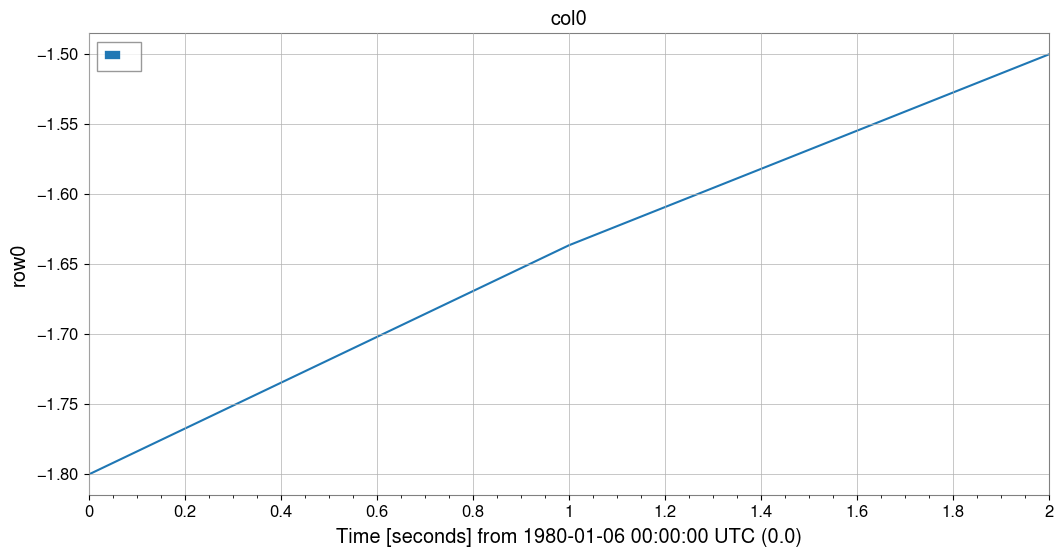

In [7]:
tr = sm_equiv.trace()
print("trace unit", tr.unit, "values", tr.value)

det_eq = sm_eq.det()
print("det unit", det_eq.unit, "values", det_eq.value)

inv_eq = sm_eq.inv(swap_rowcol=True)
print("inv shape", inv_eq.shape, "row keys", inv_eq.row_keys(), "col keys", inv_eq.col_keys())
inv_eq.plot(subplots=True);

schur_eq = sm_eq.schur(keep_rows=[0])
print("schur shape", schur_eq.shape, "unit", schur_eq.meta[0,0].unit)
schur_eq.plot(subplots=True);

### 線形代数の例外（非等価単位）

In [8]:
for op in ("det", "inv", "schur"):
    try:
        if op == "schur":
            _ = sm_mixed.schur(keep_rows=[0])
        else:
            _ = getattr(sm_mixed, op)()
    except Exception as e:
        print(f"{op} on sm_mixed ->", type(e).__name__, e)

det on sm_mixed -> UnitConversionError All element units must be equivalent for det()
inv on sm_mixed -> UnitConversionError All element units must be equivalent for inv()
schur on sm_mixed -> UnitConversionError All element units must be equivalent for schur()


## 表示系: repr / plot / step
- `repr`: テキスト表示
- `_repr_html_`: ノートブックでは `display(sm)` で表形式
- `plot` / `step`: クラスメソッドで直接描画（保存はしない）

repr:
 SeriesMatrix(shape=(2, 2, 3),  name='eq')
  epoch   : 0.0
  x0      : 0.0 s
  dx      : 1.0 s
  xunit   : s
  samples : 3

[ Row metadata ]
     name channel unit
key                   
r0   row0             
r1   row1             

[ Column metadata ]
     name channel unit
key                   
c0   col0             
c1   col1             

[ Elements metadata ]
  unit  name channel  row  col
0    m  None    None    0    0
1    m  None    None    0    1
2    m  None    None    1    0
3    m  None    None    1    1


<SeriesMatrix shape=(2, 2, 3) rows=('r0', 'r1') cols=('c0', 'c1')>

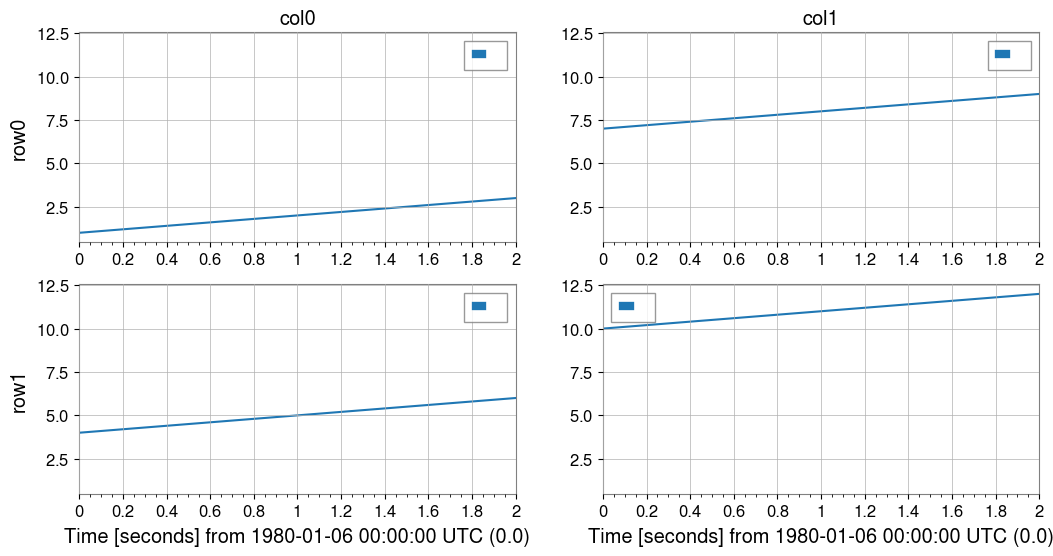

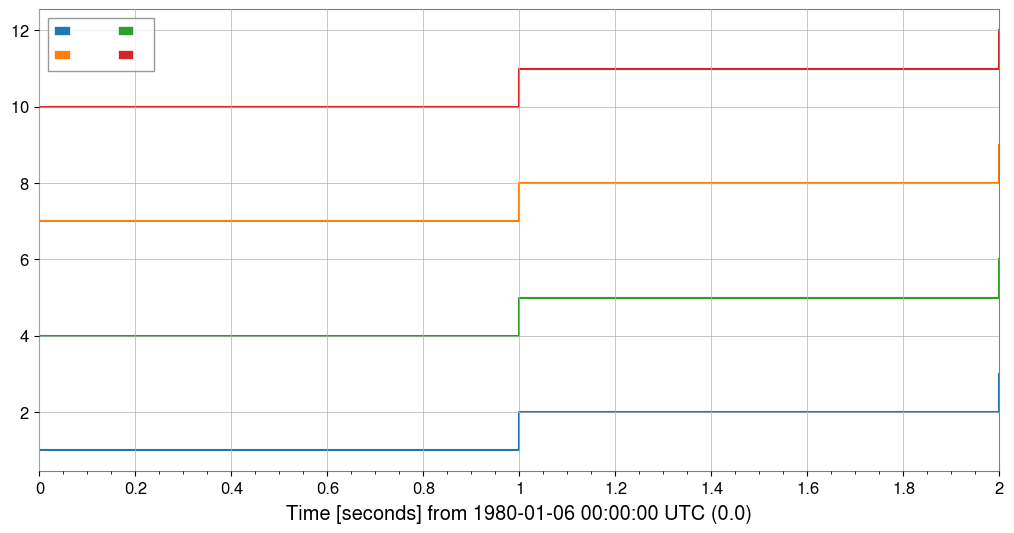

In [9]:
print("repr:\n", sm_eq)
display(sm_eq)

sm_eq.plot(subplots=True);
sm_eq.step(where="post");

## まとめ
- 要素単位を厳格に扱いながら、参照・サンプル軸編集・線形代数を実行できる。
- 行列演算は「全要素単位が等価か」を先に確認するのが重要。
- 表示はクラスメソッド (`plot`, `step`, `repr`, `_repr_html_`) をそのまま活用し、ノートブック上で結果を確認する。